# <div align="center"> <span style="font-variant:small-caps;">Reveal2Revise</span> </div>

In real-world AI applications, deep neural networks are prone to pick up spurious correlations in the training data and develop shortcut behavior. This means that models start relying on features or data artifacts that are irrelevant to the actual task, yet correlating with the target label. In particular for high-stakes applications, such as medical tasks like Melanoma detection, this can have fatal consequences, as the data artifacts do not generalize and may lead to mispredictions when deploying the model in real-world under distribution shifts, when the shortcut is not applicable. 

<div align="center">
    <img src="../static/r2r_overview_new.png" style="max-width: 800px; width: 100%;">
    <p style="text-align: center;">Reveal2Revise Overview</p>
</div>


In this notebook, we will follow the Reveal2Revise framework to validate and correct the behavior of a ResNet50 model trained on ISIC2019 for Melanoma detection from dermascopic images. 
Specifically, we will: 

- [**Compute local explanations**](#1_local_xai) for selected test samples and visualize them via heatmaps.
- [**Compute glocal (=local+global) explanations**](#2_glocal_xai) for selected test samples.
- <img src="../static/icons/step1.png" style="height: 16px; vertical-align: middle;"/> [**Model Validation**](#3_model_validation): Analyze explanations both from the data and the model perspective to identify spurious correlations.
   - <img src="../static/icons/step1a.png" style="height: 16px; vertical-align: middle;"/> [**Data perspective**](#3a_data_perspective): Are there outlier *samples*, causing the model to behave differently?
   - <img src="../static/icons/step1b.png" style="height: 16px; vertical-align: middle;"/> [**Model perspective**](#3b_model_perspective): Are there outlier model representations (i.e., neurons/concepts) behaving different from others?
   - <img src="../static/icons/step1a.png" style="height: 16px; vertical-align: middle;"/>/<img src="../static/icons/step1b.png" style="height: 16px; vertical-align: middle;"/> [**Compute Prototypical Concept-Based eXplanations (PCX)**](#3c_pcx) to analyze stereotypical prediction behavior.
- <img src="../static/icons/step2.png" style="height: 16px; vertical-align: middle;"/> [**Bias Modeling**](#4_bias_modeling) the model's prediction behavior wrt an identified spurious correlation.
- <img src="../static/icons/step3.png" style="height: 16px; vertical-align: middle;"/> [**Correct**](#5_model_correction) the model's prediction behavior wrt an identified spurious correlation.
- <img src="../static/icons/step4.png" style="height: 16px; vertical-align: middle;"/> [**Re-evaluate**](#6_evaluation) the model.

## Prerequisites

**Download Data** (from https://challenge.isic-archive.com/data/#2019):

Assuming that the data is to be stored in ```$DATA_DIR```, run:

```bash
cd $DATA_DIR
wget https://isic-challenge-data.s3.amazonaws.com/2019/ISIC_2019_Training_Input.zip
unzip https://isic-challenge-data.s3.amazonaws.com/2019/ISIC_2019_Training_Input.zip
wget https://isic-challenge-data.s3.amazonaws.com/2019/ISIC_2019_Training_GroundTruth.csv
```

**Download Pre-trained Model Checkpoint**:

Assuming that the model checkpoint is to be stored in ```$MODEL_DIR```, run:

```bash
cd $MODEL_DIR
wget https://datacloud.hhi.fraunhofer.de/s/Tq2fGgtEZ2mMFQ4/download/checkpoint_vgg16_isic_last.pth
```

**Install Required Packages**

We use Python 3.10.9 and PyTorch 1.13. 

To install the required packages, go to the root directory of this project and run:

```bash
pip install -r requirements.txt
```

In [1]:
import sys
sys.path.append('../')

import h5py
import json
import os
import numpy as np
import pandas as pd
import torch
import torchvision
from tqdm import tqdm
from torch.utils.data import DataLoader

# Plotting
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px

# Import functions for data/model handling
from datasets import load_dataset
from models import get_fn_model_loader, get_canonizer

# Import some additional helper functions
from notebooks.utils.preprocessing import precompute_activations_and_relevances
from notebooks.utils.dataset import AttackedDataset
from notebooks.utils.helpers import cosinesim_matrix, get_2d_data
from notebooks.utils.render import vis_opaque_img_border
from notebooks.utils.run_pcx import run_pcx
from notebooks.utils.plot import (plot_data, 
                                  plot_local_explanations, 
                                  plot_glocal_explanation,
                                  plot_2d_data_embedding,
                                  plot_2d_concept_embedding, 
                                  plot_pcx_matrix,
                                  plot_local_explanations_corrected)


# Import interactive Apps
from notebooks.utils.interactive_apps import (create_dash_app_data_perspective, 
                                              create_dash_app_model_perspective)

### Config
Below, you can configure the required parameters for the Reveal2Revise framework. Make sure to update the paths accordingly. Specifically, make sure to update the following values:

- `ckpt_path`: Path to the downloaded model checkpoint in `$MODEL_DIR`.
- `data_path`: Path to the directory containing the ISIC2019 dataset in `$DATA_DIR`.
- `dir_precomputed_data`: Directory where processed representations (e.g., latent activations/relevances) will be stored. Make sure to have write-permissions to that directory.

In [2]:
config = {
    "artifacts_file": "data/artifacts_isic.json",
    "dataset_name": "isic",
    "data_path": "/media/pahde/Data/ISIC2019",
    "batch_size": 12,
    "dir_precomputed_data": "/media/pahde/Data/r2r-extended/example_script/precomputed",
    
    # MODEL DETAILS
    # ---- VGG16 -------------------------------------------------------------------------------------
    "model_name": "vgg16",
    "layer_name": "features.28",
    "ckpt_path": "/media/pahde/Data/r2r-extended/example_script/models/checkpoint_vgg16_isic_last.pth",
    # ------------------------------------------------------------------------------------------------
    
    # ---- ResNet50 ----------------------------------------------------------------------------------
    # "model_name": "resnet50d",
    # "layer_name": "identity_2",
    # "ckpt_path": "/media/pahde/Data/r2r-extended/example_script/models/resnet50d_adam_lr0.0005_last.pth",
    # ------------------------------------------------------------------------------------------------
}

config["config_name"] = f"example_script_{config['dataset_name']}_{config['model_name']}_{config['layer_name']}"

with open('test_config.json', 'w') as f:
    json.dump(config, f)

## Load Model and Data

Loading the configured model and dataset. 
The dataset consists of 25,331 dermoscopic images of skin lesions to be classified into 9 benign or malginant categories: Melanoma (MEL), Melanocytic nevus (NV), Basal cell carcinoma (BCC), Actinic keratosis (AK), Benign keratosis (BKL), Dermatofibroma (DF), Vascular lesion (VASC), Squamous cell carcinoma (SCC), None of the others (UNK). The majority of samples (12875/25331 $\approx$ 50.8%) are of class NV, which is a benign skin condition.

When plotting a few samples, no obvious data-related problems are apparent at first glance. 

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

dataset = load_dataset(config, normalize_data=True)
dataset_test = dataset.get_subset_by_idxs(dataset.idxs_test)

model = get_fn_model_loader(model_name=config['model_name'])(n_class=len(dataset.classes),
                                                             ckpt_path=config['ckpt_path'], 
                                                             device=device).to(device).eval()


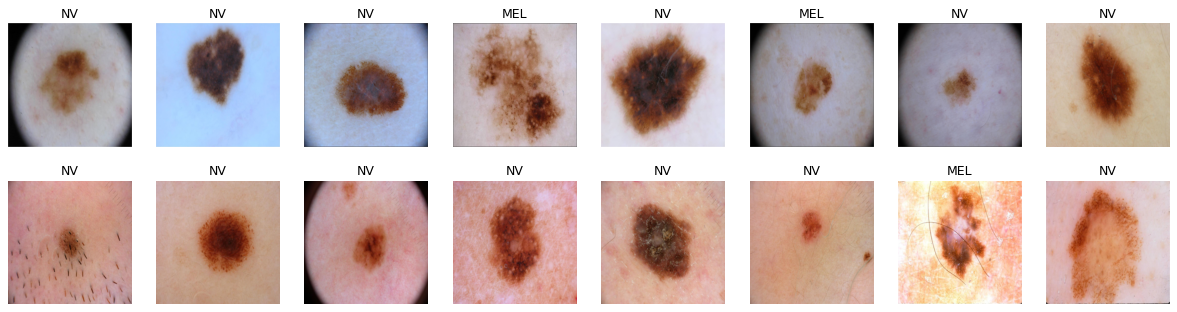

In [4]:
plot_data(dataset_test, dpi=75)

<a id='1_local_xai'></a>
# 1) Compute Local Explanation for Prediction

We use Layer-wise Relevance Propagation (LRP) to compute local explanations for single predictions. Specifically, we use the [EpsilonPlusFlat composite](https://zennit.readthedocs.io/en/latest/reference/zennit.composites.html#zennit.composites.EpsilonPlusFlat) and [model canonization](https://zennit.readthedocs.io/en/latest/reference/zennit.canonizers.html).
We utilize the implementation in [**zennit-crp**](https://github.com/rachtibat/zennit-crp), which is built upon [**zennit**](https://github.com/chr5tphr/zennit). Check out the zennit [documentation](https://zennit.readthedocs.io/en/latest/) for further details. 

We plot local explanation heatmaps for a few selected samples. While most heatmaps look reasonable, the explanation for the last prediction reveals that the model seems to be distracted by a data artifact: a colorful band-aid. In this case, even though the prediction of the model is correct (NV), it cannot be trusted, as the model does not rely on medically relevant features. 

### Configure Explainer

In [5]:
# Import CRP/zennit-crp
from crp.attribution import CondAttribution
from crp.concepts import ChannelConcept
from crp.visualization import FeatureVisualization
from crp.helper import get_layer_names
from zennit.composites import EpsilonPlusFlat

attribution = CondAttribution(model.eval().to(device))

canonizers = get_canonizer(config['model_name'])
composite = EpsilonPlusFlat(canonizers=canonizers)

In [6]:
sorted(dataset_test.sample_ids_by_artifact["band_aid"])[:6]

[52, 53, 54, 55, 56, 57]

In [7]:
SAMPLE_IDS = [2, 3, 12, 14, 56]
# SAMPLE_IDS = dataset_test.sample_ids_by_artifact["band_aid"][:5]

data = torch.stack([dataset_test[j][0] for j in SAMPLE_IDS], dim=0)
target = torch.stack([dataset_test[j][1] for j in SAMPLE_IDS], dim=0)

# Explain prediction wrt TRUE label
condition = [{"y": c_id.item()} for c_id in target]
print(condition)
attr = attribution(data.to(device).requires_grad_(), condition, composite)

[{'y': 1}, {'y': 0}, {'y': 1}, {'y': 0}, {'y': 1}]


/home/pahde/anaconda3/envs/pytorch2/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /opt/conda/conda-bld/pytorch_1712608935911/work/aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


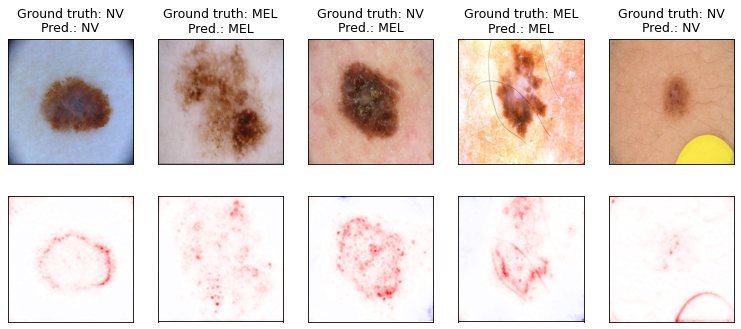

In [8]:
samples = [dataset_test.reverse_normalization(x).numpy() for x in data]
preds = attr.prediction.argmax(1)
hms = attr.heatmap.detach().cpu().numpy()
hms = (hms / attr.heatmap.flatten(start_dim=1).max(1, keepdim=True).values[:, None].cpu()).numpy()
plot_local_explanations(samples, target, preds, hms, dataset.classes, dpi=75, level=1)

&#8594; While for most input samples, the model focuses on sensible and clinically valid features, i.e., the lesion itself, for the last sample (`sample 56`), the model relies on a confounding artifact: a band-aid. 

<a id='2_glocal_xai'></a>

# 2) Glocal Explanations
## Connecting *local* explanations with *global* model insights

Next, we use [Concept Relevance Propagation (CRP)](https://www.nature.com/articles/s42256-023-00711-8) to connect local explanations for single predictions with global model insights. Specifically, given an input sample, we compute:
1. The local explanation with respect to the predicted class using LRP.
2. The most *relevant* channels (i.e., convolutional filters) of a selected layer (here: the last convolutional layer, configured above as `layer_name`)
3. Feature visualizations using RelMax for these channels. RelMax selects images from a reference dataset (e.g., the training set, but others are possible too) that achieve the highest relevance scores for the neuron (i.e., concept) of interest.
4. Concept-specific (or channel-specific) heatmaps for the given input image.

In [9]:
## CRP configuration

layer_name = config['layer_name']
MAX_MODE = "relevance"
N_CONCEPTS = 5
N_REFIMGS = 6

dataset_ref = load_dataset(config, normalize_data=False)
dataset_ref = dataset_ref.get_subset_by_idxs(dataset_ref.idxs_train)

fv_name = f"{config['dir_precomputed_data']}/crp_files/{config['dataset_name']}_train_{config['model_name']}"
cc = ChannelConcept()
layer_names = ['features.26', 'features.27', 'features.28', 'features.29']
print(f"Collecting relevances for layers: {layer_names}")
layer_map = {layer_name: cc for layer_name in layer_names}
fv = FeatureVisualization(attribution, dataset_ref, layer_map, preprocess_fn=dataset_ref.normalize_fn, path=fv_name, cache=None)

## CRP Pre-Processing

We use the [zennit-crp](https://github.com/rachtibat/zennit-crp) library for the application of CRP.
In order to visualize the concepts, zennit-crp has to run a pre-processing step. Specifically, for each neuron, zennit-crp needs to compute which samples achieve the highest activation or relevance. The pre-processing can be run as described below. However, depending on the model architecture, dataset size, and compute resources, the pre-processing can take a while. 

(Optional) Therefore, **pre-computed CRP-files** can be downloaded as follows:

1. Manually create the folder for precomputed data, as specified in the config file (for me it is `/media/pahde/Data/r2r-extended/example_script/precomputed`), from now on referred to as `$PRECOMPUTE_DIR`

```bash
mkdir $PRECOMPUTE_DIR
cd $PRECOMPUTE_DIR
```

2. Download and unpack pre-computed CRP-files for VGG16 model

```bash
gdown https://drive.google.com/uc?id=1ZeYkkBt0SK7QUJehk1R3j52sCTymcI7J
tar -xvzf precomputed_crp_files_vgg16.tgz
```

In [10]:
## (optional) run CRP preprocessing on reference dataset (alternative: download pre-computed files as described above)

if len(os.listdir(f"{fv_name}/ActMax_sum_normed")) == 0:
    fv.run(composite, 0, len(dataset_ref), batch_size=config['batch_size'])
else:
     print(f"CRP files already exist!")

CRP files already exist!


## Visualize glocal explanation

In [11]:
sample_id = 56 #53

In [12]:
# get sample and prediction. 
data_p, y = dataset_test[sample_id]
data_p = data_p.to(device).unsqueeze(0)

pred = model(data_p).detach().argmax().cpu()

# heatmaps will be computed wrt the prediction (alternative: explain wrt ground truth label)
target = pred

# backward pass to compute relevance scores for input (heatmap) and neurons in chosen layer (concepts)
attr = attribution(data_p.clone().requires_grad_(),
                   [{"y": target}],
                   composite,
                   record_layer=[layer_name])

# Compute most relevant concepts (i.e., highest absolute relevance)
channel_rels = cc.attribute(attr.relevances[layer_name], abs_norm=True)
topk = torch.topk(channel_rels[0], N_CONCEPTS)
topk_ind = topk.indices.detach().cpu().numpy()
topk_rel = topk.values.detach().cpu().numpy()

# Compute heatmaps wrt most relevant concepts in given layer
conditions = [{
    "y": target,
    layer_name: c_id
} for c_id in topk_ind]

attribution.model.zero_grad()
attr_cond = attribution(data_p.clone().requires_grad_(), conditions, composite)

# Get reference samples for most relevant concepts for feature visualization
ref_imgs = fv.get_max_reference(topk_ind, layer_name, MAX_MODE, (0, N_REFIMGS), composite=composite, 
                                rf=True, plot_fn=vis_opaque_img_border)

In [13]:
sample_img = dataset_test.reverse_normalization(data_p[0]).detach().cpu()

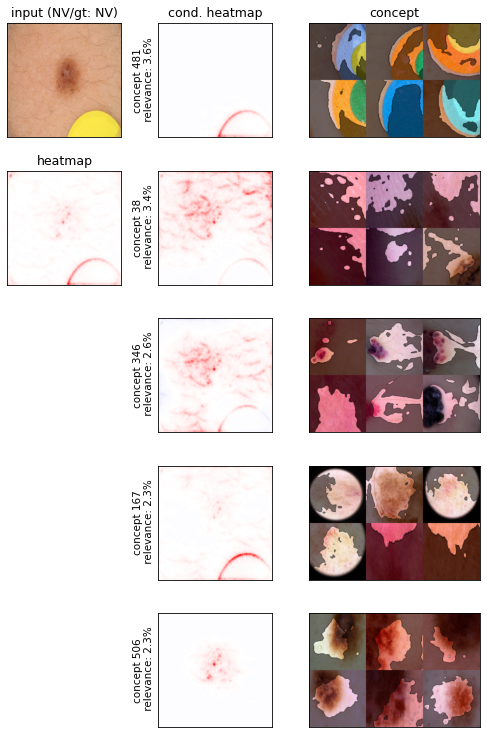

In [14]:
plot_glocal_explanation(sample_img, attr, attr_cond.heatmap, N_CONCEPTS, N_REFIMGS, topk_ind, topk_rel, ref_imgs, target, pred, y, dataset_test.classes, dpi=75, level=1)

&#8594;  It can be seen that the model relies on concepts mostly focusing on the band-aid artifact, such as concept (i.e., neuron) `481`.

<a id='3_model_validation'></a>
<div style="display: flex; align-items: center;">
    
    <h2 style="margin: 0;">3) Model Validation (step </h2>
    <img src="../static/icons/step1.png" style="height: 26px; margin-left: -20px; vertical-align: middle;"/>
    <h2 style="margin: 0;">)</h2>
</div>
However, the example provided above is an incidental discovery, made possible only because we provided the sample ID for one of the few affected images. Next, we want to validate model behavior without prior knowledge on problematic samples.

For the identification of model weaknesses, we distuingish between the data perspective and the model perspective. Both operate on input or latent activations or relevance scores, commonly in aggregated manner, for instance by applying max-pooling. Thus, all considered approaches can be run using the same pre-computed data. Whereas the data perspective computes pair-wise similarities between samples, thereby finding odd samples, the model perspective computes pair-wise similarities between neurons to identify outlier neuron/concept representations.

<div align="center">
    <img src="../static/data_vs_concept_perspective.png" style="max-width: 800px; width: 100%;">
    <p style="text-align: center;">Data- vs. model perspective for model validation</p>
</div>

### Pre-Process (or download Data for Global Analysis

The model validation from both, data and model perspective, requires latent activations or relevances for the entire dataset (see left in figure above). These scores are obtained in a pre-processing step. The pre-processing can be done by running the code in the following cell. 

Alternatively, we provide **pre-computed files** that can be downloaded as follows:

```bash
cd $PRECOMPUTE_DIR
gdown https://drive.google.com/uc?id=1Jy53H99_BeH-M8p7mQaGSuUIfhcYdT9y
tar -xvzf precomputed_global_rels_and_acts_vgg16.tgz
```

In [15]:
split = "all"

In [16]:
## (optional) pre-compute relevances and activations for all samples (alternative: download pre-computed files as described above)

path_precomputed = f"{config['dir_precomputed_data']}/global_relevances_and_activations/{config['dataset_name']}/{config['model_name']}"

# if os.path.isdir(path_precomputed) and len(os.listdir(path_precomputed)) != 0:
if os.path.isfile(f"{path_precomputed}/class_0_{split}.hdf5"):
    print(f"Latent activations/relevances already computed! ('{path_precomputed}')")
else:
    print(f"No precomputed activations found at {path_precomputed}. Running pre-processing now ...")
    precompute_activations_and_relevances(model, dataset, attribution, composite, split, layer_names, config)

Latent activations/relevances already computed! ('/media/pahde/Data/r2r-extended/example_script/precomputed/global_relevances_and_activations/isic/vgg16')


In [17]:
# The analysis is run with respect to a chosen class label, which can be configured below.

print(f"Available classes are: {dataset.classes}")

CLASS_ID = 1

print(f"Selected class: {dataset.classes[CLASS_ID]}")

Available classes are: ['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC', 'UNK']
Selected class: NV


<a id='3a_data_perspective'></a>
<div style="display: flex; align-items: center;">
    
    <h2 style="margin: 0;">3a) Data Perspective (</h2>
    <img src="../static/icons/step1a.png" style="height: 26px; margin-left: -22px; vertical-align: middle;"/>
    <h2 style="margin: 0;">)</h2>
</div>

First, we run a Spectral Relevance Analysis (SpRAy) from the data perspective, clustering relevance scores collected from the configured layer. This might reveal outlier clusters, i.e., uncommon reasoning for the prediction, which may be caused from spurious features. The embedded data matrix can be transformed to 2D for visualization using TSNE or UMAP.

We provide three different options:
1. [**Static embedding visualization**](#3a_1_static): 2D visualization of the latent relevances with highlighted pre-defined outliers. Not suitable for outlier discovery.
2. [**Scatter plot with hover information**](#3a_2_hover): 2D visualization of the latent relevances with hover information on sample IDs for outlier discovery.
3. [**Interactive Dash app**](#3a_3_interactive): Dash app for an interactive outlier discovery.

### Compute SpRAy Embedding

In the following, we compute the SpRAy embedding for the configured class.

Alternatively, we provide **pre-computed files** that can be downloaded as follows:

```bash
cd $PRECOMPUTE_DIR
gdown https://drive.google.com/uc?id=1io3DmzywMSLtvOGhRBX35gYYK0D6tYho
tar -xvzf precomputed_spray_vgg16.tgz
```


In [18]:
from experiments.preprocessing.run_spray_preprocessing import run_spray

## Run SpRAy preprocessing
if os.path.isfile(f"{config['dir_precomputed_data']}/spray/{config['dataset_name']}/{config['config_name']}_{split}.hdf5"):
    print(f"SpRAy embedding already pre-computed!")
else:
    run_spray(config=config, 
              variant="spectral",  
              split=split, 
              class_indices=[CLASS_ID], 
              n_eigval=32, 
              n_clusters=[1,2],  
              n_neighbors=32)

SpRAy embedding already pre-computed!


In [19]:
emb_type_spray = "tsne"

In [20]:
# Load SpRAy embedding
analysis_file = f"{config['dir_precomputed_data']}/spray/{config['dataset_name']}/{config['config_name']}_{split}.hdf5"
with h5py.File(analysis_file, 'r') as fp:
    sample_ids = np.array(fp[str(CLASS_ID)]['index'])
    data_2d = fp[str(CLASS_ID)]['embedding'][emb_type_spray][::1]
    
print(data_2d.shape)

(12875, 2)


<a id='3a_1_static'></a>

### Option 1: Static embedding visualization

First, we create a (static) 2D representation of latent relevance scores on the configured layer. We highlight pre-defined (outlier) samples in orange. They all contain the band-aid artifact and clearly appear as outlier samples.

In [21]:
samples_2d_pd = pd.DataFrame({
    "x": data_2d[:, 0],
    "y": data_2d[:, 1],
    "id": np.arange(len(data_2d))
})

samples_2d_pd[["x", "y"]] /= np.abs(samples_2d_pd[["x", "y"]].values).max()

In [22]:
# We create a copy pf the dataset ONLY containing samples form the configured class

idxs_split = {"train": dataset.idxs_train, "val": dataset.idxs_val, "test": dataset.idxs_test, "all": np.arange(len(dataset))}[split]
dataset_split = dataset.get_subset_by_idxs(idxs_split)
dataset_cl = dataset_split.get_subset_by_idxs(np.where(dataset_split.metadata[dataset.classes[CLASS_ID]].values == 1)[0])
print(f"There are {len(dataset_cl)} samples with class_id {CLASS_ID}")

There are 12875 samples with class_id 1


In [23]:
# pre-defined outlier samples
outlier_samples = [363, 364, 365, 368, 370, 371, 372, 373, 374, 375, 376, 377, 380, 385, 390, 391, 392, 393]# [276, 277, 278, 280, 281, 282, 283, 284, 285, 286, 287, 288] #[368,519,434,399,430,451,503,416,372,390,540,9841]# [396, 412, 392, 406, 502, 422, 427, 446, 537, 394, 474, 363]
outlier_labels = np.zeros(len(data_2d)).astype(np.uint8)
outlier_labels[outlier_samples] = 1
sizes = [2 if is_outlier else 0.4 for is_outlier in outlier_labels]

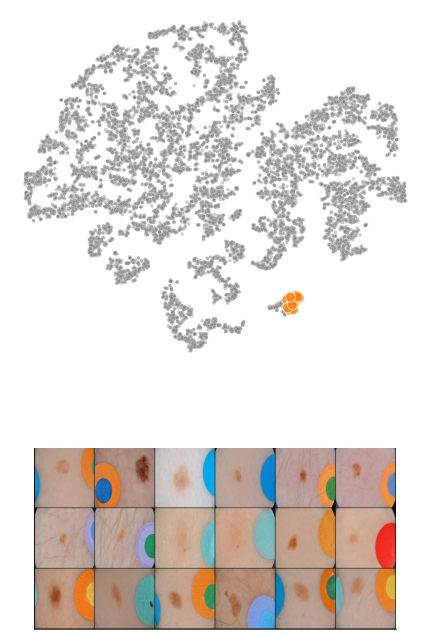

In [24]:
outlier_imgs = [dataset.reverse_normalization(dataset_cl[i][0]) for i in outlier_samples]

plot_2d_data_embedding(data_2d, outlier_labels, outlier_imgs, dpi=60)

<a id='3a_2_hover'></a>

### Option 2: Scatter plot with hover information

As a slighlty more interactive version, this option provides the sample ID as hover information. You can modify the outlier IDs above for visualization.

In [25]:
## UNCOMMENT TO RUN

# fig = px.scatter(samples_2d_pd, x="x", y="y", hover_name="id", color=outlier_labels, size=sizes, width=600, height=600)
# fig.update_layout(showlegend=False)
# fig.show()

<a id='3a_3_interactive'></a>

### Option 3: Interactive Data Discovery
**NOTE**: make sure to be connected to the specified port. For instance, run `ssh COMPUTE_NODE -L 8050:localhost:8050` if you use port `8050` on the machine accessible via `COMPUTE_NODE`.

Lastly, we provide an interactive app allowing to select (outlier) regions in the plot and get all samples within that region along with their sample IDs.

In [26]:
## UNCOMMENT TO RUN

# # Run the app inline
# PORT_DASH_APP = 8050

# app = create_dash_app_data_perspective(samples_2d_pd, dataset_cl, percentage_images=0.025)
# app.run_server(debug=True, port=PORT_DASH_APP)

<a id='3b_model_perspective'></a>

<div style="display: flex; align-items: center;">
    
    <h2 style="margin: 0;">3b) Model Perspective (</h2>
    <img src="../static/icons/step1b.png" style="height: 26px; margin-left: -22px; vertical-align: middle;"/>
    <h2 style="margin: 0;">)</h2>
</div>

Next, instead of trying to identify outlier *samples* for which the model used a unique prediction behavior, we now seek for outlier *model representations*, i.e., neurons (or concepts). Therefore, we leverage the same pre-computed data, i.e., latent relevance scores for the pre-configured layer.

We provide two different options:
1. [**Static concept embedding visualization**](#3b_1_static): 2D visualization of the latent concept relevances with highlighted pre-defined outlier concepts. Not suitable for outlier discovery.
2. [**Scatter plot with hover information**](#3b_2_hover): 2D visualization of the latent concept relevances with hover information on concept IDs for outlier discovery.
3. [**Interactive Dash app**](#3b_3_interactive): Dash app for an interactive discovery of outlier concepts.

In [27]:
# pick between 'umap' and 'tsne'
algorithm = "umap"

In [28]:
# Load pre-computed activations/relevances

with h5py.File(f"{path_precomputed}/class_{CLASS_ID}_{split}.hdf5", 'r') as file:
    layer_data = file[config['layer_name']]
    data_latent = torch.tensor(np.array(layer_data["rels_max"]))
    
print(f"Loaded precomputed relevances wrt class '{CLASS_ID}' for layer {config['layer_name']} of shape {data_latent.shape}")

Loaded precomputed relevances wrt class '1' for layer features.28 of shape torch.Size([12875, 512])


In [29]:
# Compute pair-wise cosine similarities
similarities = cosinesim_matrix(data_latent.transpose(0,1))
print(similarities.shape)

# Embed in 2D
D = (1-similarities).clamp(min=0)
data_2d = get_2d_data(D, algorithm=algorithm, metric="precomputed")
print(f"New shape: {data_2d.shape}")

torch.Size([512, 512])
New shape: (512, 2)


<a id='3b_1_static'></a>

### Option 1: Static concept embedding visualization

First, we create a (static) 2D representation of latent concept relevance scores on the configured layer. 
We highlight pre-defined (outlier) concepts in orange, along with the concept (neuron) visualization via RelMax.
All selected neurons appear to extract the `band-aid`-concept.

In [30]:
concept_2d_pd = pd.DataFrame({
    "x": data_2d[:, 0],
    "y": data_2d[:, 1],
    "id": np.arange(len(data_2d))
})

concept_2d_pd[["x", "y"]] /= np.abs(concept_2d_pd[["x", "y"]].values).max()

In [31]:
# MODIFY PRE_SELECTED OUTLIER CONCEPTS HERE:

outlier_concepts = [308, 389, 481] #[120, 273, 401] #[169,481] # [481,308] # [480,757,829]
outlier_labels = np.zeros(len(data_2d)).astype(np.uint8)
outlier_labels[outlier_concepts] = 1
sizes = [2 if is_outlier else 0.4 for is_outlier in outlier_labels]

In [32]:
# Define outlier concepts and retrieve reference samples
ref_imgs_outlier_concepts = fv.get_max_reference(outlier_concepts, layer_name, "relevance", (0, 5), composite=composite, rf=True,
                                                 plot_fn=vis_opaque_img_border)

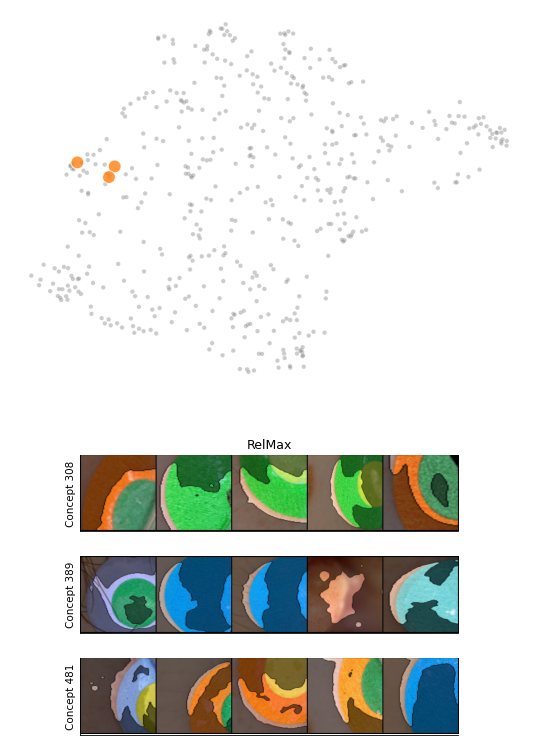

In [33]:
plot_2d_concept_embedding(data_2d, outlier_concepts, ref_imgs_outlier_concepts, dpi=75)

<a id='3b_2_hover'></a>

### Option 2: Scatter plot with hover information

As a slighlty more interactive version, this option provides the concept ID (i.e., the neuron index) as hover information. You can modify the outlier IDs above for visualization.

In [34]:
# Create a scatter plot

## UNCOMMENT TO RUN

# fig = px.scatter(concept_2d_pd, x="x", y="y", hover_name="id", color=outlier_labels, size=sizes, size_max=10, width=600, height=600)
# fig.update_layout(showlegend=False)
# fig.show()

<a id='3b_3_interactive'></a>

### Option 3: Interactive Concept Discovery
**NOTE**: make sure to be connected to the specified port. For instance, run `ssh COMPUTE_NODE -L 8050:localhost:8050` if you use port `8050` on the machine accessible via `COMPUTE_NODE`.

Lastly, we provide an interactive app allowing to select (outlier) regions in the plot and get all concepts within that region along with their concept visualization via RelMax.

This requires the pre-computation of *all* concept visualizations. This may take a few minutes.

In [35]:
## precompute all concept visualuzations 
## NOTE: This may take a few minutes.

ref_imgs_all_concepts = {cid: fv.get_max_reference(cid, layer_name, "relevance", (0, 16), composite=composite, rf=True,
                                                   plot_fn=vis_opaque_img_border)[cid] for cid in tqdm(range(len(concept_2d_pd)))}

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [05:17<00:00,  1.61it/s]


In [36]:
## UNCOMMENT TO RUN

# app = create_dash_app_model_perspective(concept_2d_pd, ref_imgs_all_concepts, percentage_images=0.1)
# app.run_server(mode='inline', debug=True, port=8050)

<a id='3c_pcx'></a>

<div style="display: flex; align-items: center;">
    
    <h2 style="margin: 0;">3c) PCX: Combining both perspectives (</h2>
    <img src="../static/icons/step1a.png" style="height: 26px; margin-left: -22px; vertical-align: middle;"/>
    <h2 style="margin: 0;">/</h2>
    <img src="../static/icons/step1b.png" style="height: 26px; margin-left: -22px; vertical-align: middle;"/>
    <h2 style="margin: 0;">)</h2>
</div>

Lastly, we combine both perspectives by computing prototypical concept-based explanations (PCX). This involves clustering (latent) relevance scores from the data perspective using a Gaussian Mixture Model (GMM), and interpreting cluster centers as distribution over concepts (model perspective). This can be visualized as matrix, where columns represent prototypes with representative samples, rows represent concepts (visualized via RelMax) and the values in the matrix indicate the average relevance of the concept for the prototype. 

In [37]:
## PCX configuration
class_id = 1
n_prototypes = 8
top_k_sample_prototype = 4
n_per_prototype = 2
num_ref_concept = 4
layer_name = config['layer_name']

In [38]:
# Load pre-computed relevances
features_samples = torch.tensor(np.array(
    h5py.File(f"{path_precomputed}/class_{class_id}_{split}.hdf5")[layer_name]["rel"]
))

# Load pre-computed outputs, ground truth classes, and sample_ids
metadata = torch.load(f"{path_precomputed}/class_{class_id}_{split}_meta.pth")
sample_ids = np.array(metadata["samples"])
outputs = metadata["output"]
classes = np.array([dataset.get_target(i) for i in sample_ids])

In [39]:
# Run PCX analysis to compute the concept matrix
concept_matrix, prototype_samples, counts, counts_perc, topk_ind = run_pcx(features_samples,
                                                                           outputs,
                                                                           classes,
                                                                           sample_ids,
                                                                           class_id,
                                                                           n_prototypes,
                                                                           top_k_sample_prototype,
                                                                           n_per_prototype)

Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged: True
Initialization 1
  Iteration 10
  Iteration 20
Initialization converged: True
Initialization 2
  Iteration 10
  Iteration 20
Initialization converged: True


#### Visualize PCX results by plotting the concept matrix.

- Columns represent prototypes with representative samples.
- Rows represent concepts (visualized via RelMax).
- Values in the matrix indicate the average relevance of the concept for the prototype. 

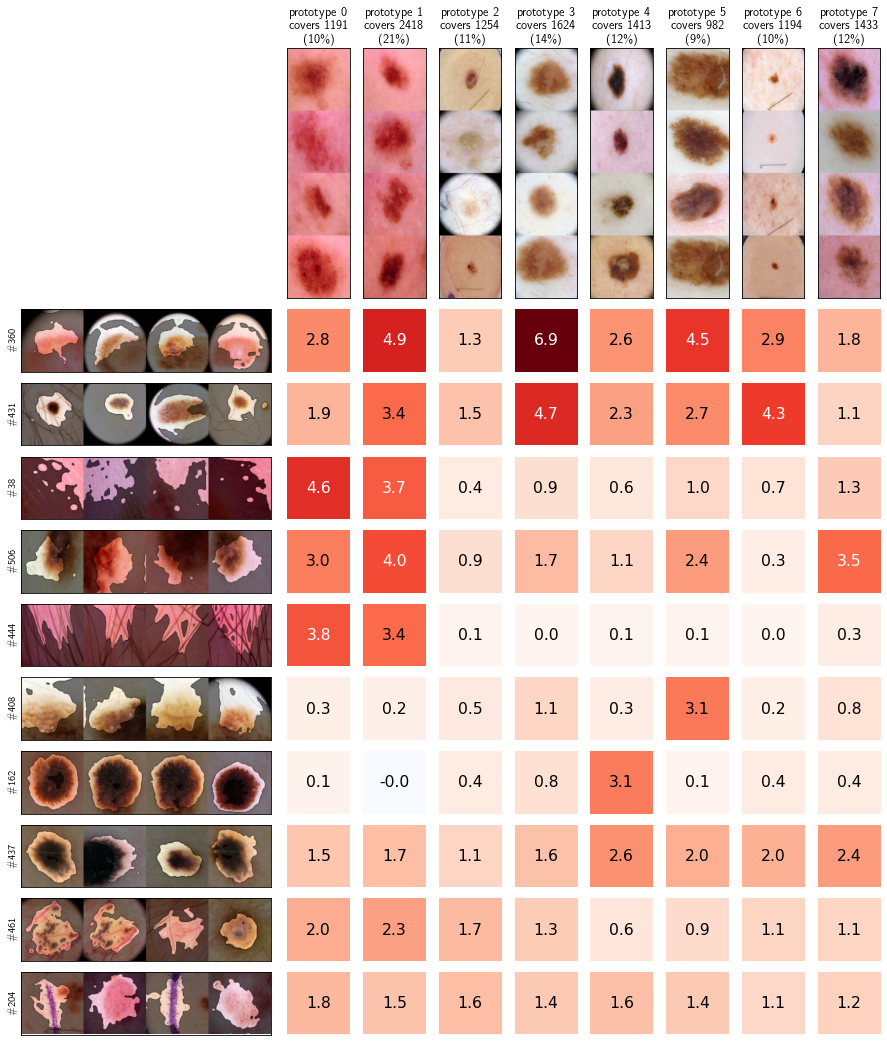

In [40]:
plot_pcx_matrix(concept_matrix, dataset, prototype_samples, ref_imgs_all_concepts, counts, 
                counts_perc, topk_ind, num_ref_concept, top_k_sample_prototype, None, dpi=75)


<a id='4_bias_modeling'></a>

<div style="display: flex; align-items: center;">
    
    <h2 style="margin: 0;">4) Bias Modeling (step </h2>
    <img src="../static/icons/step2.png" style="height: 26px; margin-left: -20px; vertical-align: middle;"/>
    <h2 style="margin: 0;">)</h2>
</div>

This bias modeling steps involves the computation of a suitable bias represention within the model's latent space.
Note, that the model correction implementation (here: RR-ClArC) computes the bias representation internally given sample-wise bias labels. 
Hence, we only need a list of bias samples as positive examples for the CAV computation.
This list is stored as JSON and provided to the model correction step below.

In [41]:
ARTIFACT_NAME = "band_aid"

artifact_samples = {
 ARTIFACT_NAME: [
  "ISIC_0001449_downsampled", "ISIC_0002459_downsampled", "ISIC_0001385_downsampled", "ISIC_0002287_downsampled", "ISIC_0008294_downsampled", "ISIC_0002829_downsampled", "ISIC_0002948_downsampled", "ISIC_0004168_downsampled", "ISIC_0009564_downsampled", "ISIC_0001427_downsampled", "ISIC_0006815_downsampled", "ISIC_0000900_downsampled", "ISIC_0007087_downsampled", "ISIC_0001213_downsampled", "ISIC_0007788_downsampled", "ISIC_0008507_downsampled", "ISIC_0001188_downsampled", "ISIC_0001254_downsampled", "ISIC_0006612_downsampled",
  "ISIC_0002976_downsampled", "ISIC_0007528_downsampled", "ISIC_0001423_downsampled", "ISIC_0008524_downsampled", "ISIC_0005564_downsampled", "ISIC_0009188_downsampled", "ISIC_0002647_downsampled", "ISIC_0006114_downsampled", "ISIC_0005555_downsampled", "ISIC_0004309_downsampled", "ISIC_0001286_downsampled", "ISIC_0005247_downsampled", "ISIC_0008145_downsampled", "ISIC_0008879_downsampled", "ISIC_0007760_downsampled", "ISIC_0001187_downsampled", "ISIC_0001372_downsampled", "ISIC_0008025_downsampled", "ISIC_0009505_downsampled",
  "ISIC_0003462_downsampled", "ISIC_0005620_downsampled", "ISIC_0006671_downsampled", "ISIC_0008406_downsampled", "ISIC_0009344_downsampled", "ISIC_0004115_downsampled", "ISIC_0006651_downsampled", "ISIC_0005639_downsampled", "ISIC_0002353_downsampled", "ISIC_0003559_downsampled", "ISIC_0009583_downsampled", "ISIC_0002975_downsampled", "ISIC_0001292_downsampled", "ISIC_0002673_downsampled", "ISIC_0009165_downsampled", "ISIC_0008528_downsampled", "ISIC_0009800_downsampled", "ISIC_0005000_downsampled", "ISIC_0013333_downsampled",
  "ISIC_0004166_downsampled", "ISIC_0009533_downsampled", "ISIC_0009298_downsampled", "ISIC_0008116_downsampled", "ISIC_0002469_downsampled", "ISIC_0001212_downsampled", "ISIC_0008600_downsampled", "ISIC_0005787_downsampled", "ISIC_0002107_downsampled", "ISIC_0009035_downsampled", "ISIC_0003346_downsampled", "ISIC_0009430_downsampled", "ISIC_0002780_downsampled", "ISIC_0003657_downsampled", "ISIC_0007332_downsampled", "ISIC_0002879_downsampled", "ISIC_0001262_downsampled", "ISIC_0006982_downsampled", "ISIC_0001871_downsampled",
  "ISIC_0007344_downsampled", "ISIC_0008029_downsampled", "ISIC_0004110_downsampled", "ISIC_0002885_downsampled", "ISIC_0008659_downsampled", "ISIC_0006776_downsampled", "ISIC_0001204_downsampled", "ISIC_0008785_downsampled", "ISIC_0002488_downsampled", "ISIC_0008207_downsampled", "ISIC_0008807_downsampled", "ISIC_0004715_downsampled", "ISIC_0002374_downsampled", "ISIC_0006914_downsampled", "ISIC_0001306_downsampled", "ISIC_0002476_downsampled", "ISIC_0003056_downsampled", "ISIC_0002438_downsampled", "ISIC_0003174_downsampled",
  "ISIC_0009758_downsampled", "ISIC_0008403_downsampled", "ISIC_0005666_downsampled", "ISIC_0001442_downsampled", "ISIC_0001216_downsampled", "ISIC_0004337_downsampled", "ISIC_0005187_downsampled", "ISIC_0001374_downsampled", "ISIC_0006795_downsampled", "ISIC_0001852_downsampled", "ISIC_0007796_downsampled", "ISIC_0003005_downsampled", "ISIC_0003539_downsampled", "ISIC_0001267_downsampled", "ISIC_0009160_downsampled", "ISIC_0001296_downsampled", "ISIC_0004985_downsampled", "ISIC_0007241_downsampled", "ISIC_0007235_downsampled",
  "ISIC_0009297_downsampled", "ISIC_0007693_downsampled", "ISIC_0008280_downsampled", "ISIC_0001185_downsampled", "ISIC_0007475_downsampled", "ISIC_0006711_downsampled", "ISIC_0001299_downsampled", "ISIC_0009083_downsampled", "ISIC_0008347_downsampled", "ISIC_0002453_downsampled", "ISIC_0009078_downsampled", "ISIC_0006800_downsampled", "ISIC_0005548_downsampled", "ISIC_0008256_downsampled", "ISIC_0007322_downsampled", "ISIC_0002206_downsampled", "ISIC_0006940_downsampled", "ISIC_0001367_downsampled", "ISIC_0013229_downsampled",
  "ISIC_0001769_downsampled", "ISIC_0001247_downsampled", "ISIC_0014535_downsampled", "ISIC_0002093_downsampled", "ISIC_0006326_downsampled", "ISIC_0009201_downsampled", "ISIC_0007141_downsampled", "ISIC_0001186_downsampled", "ISIC_0003308_downsampled", "ISIC_0001163_downsampled", "ISIC_0000999_downsampled", "ISIC_0002489_downsampled", "ISIC_0002251_downsampled", "ISIC_0002246_downsampled", "ISIC_0006021_downsampled", "ISIC_0003805_downsampled", "ISIC_0001191_downsampled", "ISIC_0012469_downsampled", "ISIC_0009504_downsampled",
  "ISIC_0004346_downsampled", "ISIC_0008552_downsampled", "ISIC_0003051_downsampled", "ISIC_0008913_downsampled", "ISIC_0001275_downsampled", "ISIC_0007557_downsampled", "ISIC_0003582_downsampled", "ISIC_0009252_downsampled", "ISIC_0006193_downsampled", "ISIC_0008541_downsampled", "ISIC_0008236_downsampled", "ISIC_0002806_downsampled", "ISIC_0007156_downsampled", "ISIC_0002439_downsampled", "ISIC_0008626_downsampled", "ISIC_0008993_downsampled", "ISIC_0007038_downsampled", "ISIC_0001960_downsampled", "ISIC_0009599_downsampled",
  "ISIC_0001242_downsampled", "ISIC_0006350_downsampled", "ISIC_0002836_downsampled", "ISIC_0002871_downsampled", "ISIC_0001181_downsampled", "ISIC_0002616_downsampled", "ISIC_0001184_downsampled", "ISIC_0001190_downsampled", "ISIC_0008992_downsampled", "ISIC_0009860_downsampled", "ISIC_0014136_downsampled", "ISIC_0000882_downsampled", "ISIC_0003728_downsampled"
 ]
}

path_biased_samples = f"artifact_samples_{config['dataset_name']}.json"
with open(path_biased_samples, 'w') as f:
    json.dump(artifact_samples, f)
print(f"stored list of biased samples to to {path_biased_samples}")

stored list of biased samples to to artifact_samples_isic.json


<a id='5_model_correction'></a>

<div style="display: flex; align-items: center;">
    
    <h2 style="margin: 0;">5) Model Correction (step </h2>
    <img src="../static/icons/step3.png" style="height: 26px; margin-left: -20px; vertical-align: middle;"/>
    <h2 style="margin: 0;">)</h2>
</div>

Next, we correct the model behavior wrt the discovered bias with the bias mitigation method [RR-ClArC](https://arxiv.org/abs/2308.09437). This approach involves a fine-tuning stage, in which the model is penalized for relying on features (computed via the gradient) pointing into the bias direction (modeled via CAV). The fine-tuning details are specified below. 

*(Optional)* Instead of fine-tuning the model yourself, feel free to **download the pre-corrected model checkpoint**. 
Make sure to store the checkpoint at the location configured in the configuration file in the following cell (for me, it is `/media/pahde/Data/r2r-extended/example_script/models_corrected/`).

```bash
cd $CORRECTED_MODELS_DIR
gdown https://drive.google.com/uc?id=1KABd8Jtwqn-uba2pLHcgTgjQgBUDMLCn
tar -xvzf model_corrected_vgg16.tgz
```

In [42]:
from experiments.mitigation_experiments.start_model_correction import start_model_correction

config_correction = {
    "artifacts_file": path_biased_samples,
    "num_epochs": 10,
    "batch_size": 64,
    "optimizer": "sgd",
    "lr": 0.0001,
    "loss": "cross_entropy",
    "artifact": ARTIFACT_NAME,
    "method": "RRClarc",
    "lamb": 10e6,
    "direction_mode": "signal",
    "cav_mode": "cavs_max",
    "cav_scope": [1],
    "criterion": "all_logits_random",
    "checkpoint_dir_corrected": f"/media/pahde/Data/r2r-extended/example_script/models_corrected/"
}

path_config = f"test_config_{config['model_name']}.json"
with open(path_config, 'w') as f:
    json.dump({**config, **config_correction}, f)
print(f"stored fine-tuning config to {path_config}")

ckpt_corrected_path = f"{config_correction['checkpoint_dir_corrected']}/{config['config_name']}/last.ckpt"

if os.path.isfile(ckpt_corrected_path):
    print(f"Model already corrected. Loading checkpoint from {ckpt_corrected_path}")
else:
    start_model_correction({**config, **config_correction}, num_gpu=1)

stored fine-tuning config to test_config_vgg16.json
Model already corrected. Loading checkpoint from /media/pahde/Data/r2r-extended/example_script/models_corrected//example_script_isic_vgg16_features.28/last.ckpt


<a id='6_evaluation'></a>

<div style="display: flex; align-items: center;">
    
    <h2 style="margin: 0;">6) Model (Re-)evaluation (step </h2>
    <img src="../static/icons/step4.png" style="height: 26px; margin-left: -20px; vertical-align: middle;"/>
    <h2 style="margin: 0;">)</h2>
</div>

As last step of the <span style="font-variant:small-caps;">Reveal2Revise</span> framework, we want to re-evaluate the model in terms of (1) preditive performance and (2) remaining reliance on the bias.

We implemented the following three quantitative and qualitative evaluations:
1. [**(Quantitative) Accuracy under varying bias distributions**](#6a_accuracy): Measuring and comparing the performances (accuracy) of the original and corrected models on a clean test set (without bias samples) and an attacked test set, where the bias is cropped from known bias samples and artificially inserted into (previously) clean samples .
2. [**(Qualitative) Explanation heatmaps**](#6b_heatmaps): Visualizing the explanation heatmaps, computed via LRP, for the predictions of biases samples for the original and corrected models.
3. [**(Quantitative) Artifact Relevance**](#6c_artifact_relevance): Computation and comparison of the fraction of relevance put onto artifact regions for the original and corrected models.

In [43]:
## Load corrected model
model_corrected = get_fn_model_loader(model_name=config['model_name'])(n_class=len(dataset.classes),
                                                                       ckpt_path=ckpt_corrected_path, 
                                                                       device=device).to(device).eval()

attribution_corrected = CondAttribution(model_corrected)

2025-09-18 17:52:10,627 - Loading vgg16


<a id='6a_accuracy'></a>
### 6a) Evaluate accuracy on clean/attacked data
First, we load a clean and an attacked test set.
For the latter, we crop the artifact from known biased samples using artifact localization masks and copy them onto (previously) clean samples. 
Models the utilize the bias concept are expected to perform poorly on the attacked test set, while robust models are expected to be less sensitive towards the attack.
We first visualize attacked test samples, then evaluate both models (original and corrected) on both test sets (clean and attacked) and plot the resulting accuracies.

In [44]:
## Load dataset attacked
config['artifact'] = "band_aid"
config['masks_location'] = "../data"
ds_hm = load_dataset(config, hm=True, normalize_data=True)

ds_attacked = AttackedDataset(ds_hm, "band_aid")

ds_clean_test = ds_hm.get_subset_by_idxs(ds_hm.idxs_test)
ds_attacked_test = ds_attacked.get_subset_by_idxs(ds_hm.idxs_test)

print(len(ds_attacked_test))

2025-09-18 17:52:14,229 - Loading isic_hm


LOADING band_aid
Localized artifacts: 184
Collected 184 artifact samples
2533


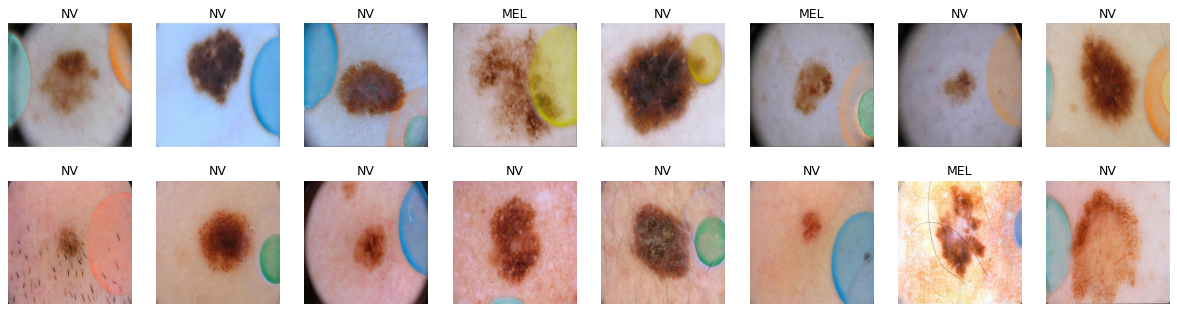

In [45]:
# Examples for "attacked" test samples

plot_data(ds_attacked_test, dpi=75)

In [46]:
# Evaluate both models (original and corrected) on both test sets (clean and attacked), leading to 4 evaluation runs.

BATCH_SIZE = 16

def evaluate(model, ds, batch_size):
    dl = DataLoader(ds, batch_size=batch_size, shuffle=False)

    preds = []
    ys = []

    for batch in tqdm(dl):
        if len(batch) == 2:
            x, y = batch
        else:
            x, y, m = batch

        preds.append(model(x.to(device)).detach().cpu().argmax(1))
        ys.append(y)
        
    ys = torch.cat(ys)
    preds = torch.cat(preds)
    acc = (ys == preds).numpy().mean()
    return acc

print("Evaluate original model on clean data")
acc_original_clean = evaluate(model, ds_clean_test, BATCH_SIZE)

print("Evaluate corrected model on clean data")
acc_corrected_clean = evaluate(model_corrected, ds_clean_test, BATCH_SIZE)

print("Evaluate original model on attacked data")
acc_original_att = evaluate(model, ds_attacked_test, BATCH_SIZE)

print("Evaluate corrected model on attacked data")
acc_corrected_att = evaluate(model_corrected, ds_attacked_test, BATCH_SIZE)

Evaluate original model on clean data


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 159/159 [01:04<00:00,  2.45it/s]


Evaluate corrected model on clean data


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 159/159 [01:04<00:00,  2.45it/s]


Evaluate original model on attacked data


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 159/159 [01:05<00:00,  2.42it/s]


Evaluate corrected model on attacked data


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 159/159 [01:06<00:00,  2.39it/s]


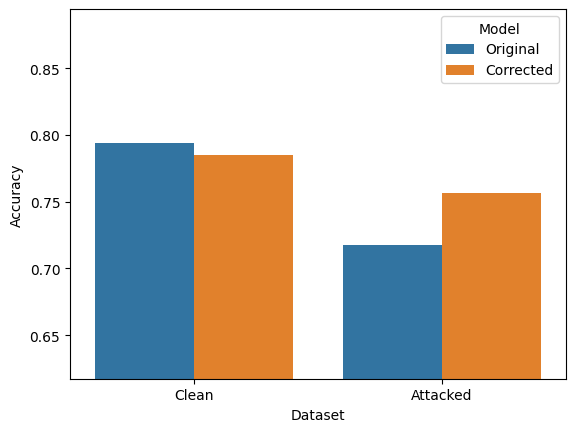

In [47]:
results = pd.DataFrame([
    (acc_original_clean,  "Original", "Clean"),
    (acc_original_att,  "Original", "Attacked"),
    (acc_corrected_clean,  "Corrected", "Clean"),
    (acc_corrected_att,  "Corrected", "Attacked")
], columns=["Accuracy", "Model", "Dataset"])

sns.barplot(results, x="Dataset", y="Accuracy", hue="Model")
plt.ylim(results["Accuracy"].min() - .1, min(results["Accuracy"].max() + .1, 1))
plt.show()

&#8594; Ideally, in comparison with the original model (blue), the corrected model (orange) performs approximately **similar or even better on the clean** test set (*model correction does not hurt performance*) and **significantly better on the attacked** test set (*corrected model is more robust towards the bias*).

<a id='6b_heatmaps'></a>
### 6b) Plot Explanation Heatmaps for Biased Samples

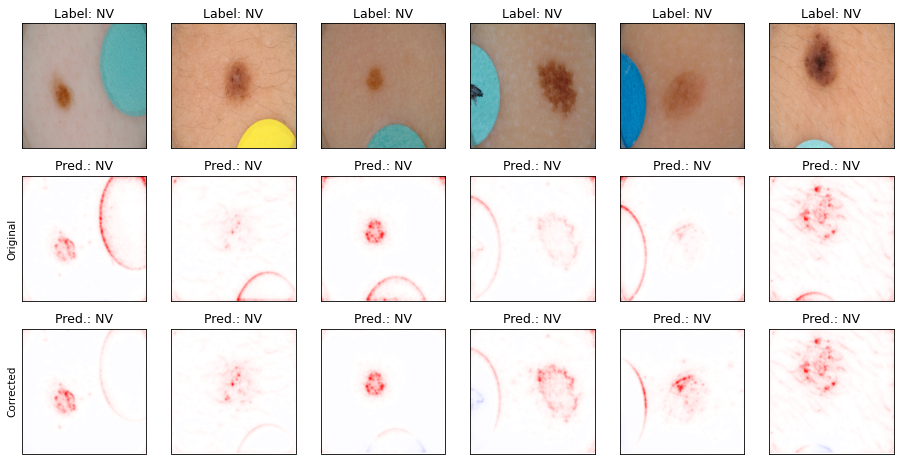

In [48]:
SAMPLE_IDS =[59, 56, 64, 65, 60, 57]

data = torch.stack([ds_clean_test[j][0] for j in SAMPLE_IDS], dim=0)
target = torch.stack([ds_clean_test[j][1] for j in SAMPLE_IDS], dim=0)

# Compute predictions
preds_original = model(data.to(device)).detach().cpu().argmax(1)
preds_corrected = model_corrected(data.to(device)).detach().cpu().argmax(1)

# Explain prediction wrt PREDICTION
condition_original = [{"y": p.item()} for p in preds_original]
attr_original = attribution(data.clone().to(device).requires_grad_(), condition_original, composite)

condition_corrected = [{"y": p.item()} for p in preds_corrected]
attr_corrected = attribution_corrected(data.clone().to(device).requires_grad_(), condition_corrected, composite)

# Get non-normalized input images
imgs = [ds_attacked_test.reverse_normalization(x).numpy() for x in data]

# Normalize heatmaos
hms_original = attr_original.heatmap.detach().cpu().numpy()
hms_original /= hms_original.max(axis=(1,2), keepdims=True)

hms_corrected = attr_corrected.heatmap.detach().cpu().numpy()
hms_corrected /= hms_corrected.max(axis=(1,2), keepdims=True)

# Create plots
plot_local_explanations_corrected(imgs, target, preds_original, preds_corrected, hms_original, hms_corrected, ds_attacked_test.classes, dpi=75)

&#8594; Ideally, after model correction, the model puts **less** relevance on artifact regions and **more** relevance on clinically valid features, i.e., the lesion itself. 

<a id='6c_artifact_relevance'></a>
### 6c) Compute artifact relevance

Lastly, we compute the artifact relevance, i.e., the fraction of total (absolute) relevance put onto the artifact region (specified via localization masks), computed via a local explanation methods (here: LRP). 
We compute the artifact relevance on all bias samples (e.g., containing a band-aid) from the test set.

In [49]:
split = "test"
artifact = "band_aid"

idxs_splits = {
    "train": ds_hm.idxs_train,
    "val": ds_hm.idxs_val,
    "test": ds_hm.idxs_test
}

In [50]:
artifact_ids = ds_hm.sample_ids_by_artifact[artifact]
split_ids = idxs_splits[split]

sample_ids = [i for i in split_ids if i in artifact_ids]

ds_hm_split = ds_hm.get_subset_by_idxs(sample_ids)

print(f"Found {len(ds_hm_split)} relevant samples.")

Found 22 relevant samples.


In [51]:
def compute_artifact_relevance(model, ds, batch_size=8):
    gaussian = torchvision.transforms.GaussianBlur(kernel_size=41, sigma=8.0)
    dl = DataLoader(ds, batch_size=batch_size, shuffle=False)
    attribution = CondAttribution(model)
    
    scores = []
    for batch in tqdm(dl):
        x, y, mask = batch
        condition = [{"y": t} for t in y]
        attr = attribution(x.to(device).requires_grad_(), condition, composite, init_rel=1)
        
        mask = 1.0 * (mask / mask.abs().flatten(start_dim=1).max(1)[0][:, None, None] > 0.1)
        mask = gaussian(mask.clamp(min=0)) ** 1.0
        mask = 1.0 * (mask / mask.abs().flatten(start_dim=1).max(1)[0][:, None, None] > 0.3)
        mask = mask.to(device)
        
        inside = (attr.heatmap * mask).abs().sum((1, 2)) / (attr.heatmap.abs().sum((1, 2)) + 1e-10)
        scores.extend(inside.cpu().numpy())
        
    return np.array(scores).mean()
#     preds.append(model(x.to(device)).detach().cpu().argmax(1))

In [52]:
art_rel_original = compute_artifact_relevance(model, ds_hm_split)
art_rel_corrected = compute_artifact_relevance(model_corrected, ds_hm_split)
art_rel_corrected
print(f"{art_rel_original:.3f} / {art_rel_corrected:.3f}")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.94it/s]

0.462 / 0.236


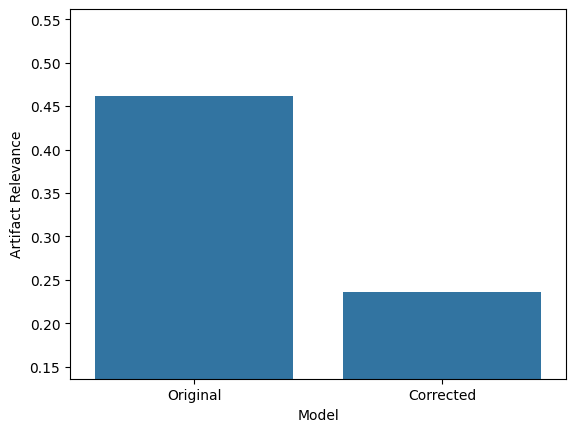

In [53]:
results = pd.DataFrame([
    (art_rel_original,  "Original"),
    (art_rel_corrected,  "Corrected")
], columns=["Artifact Relevance", "Model"])

sns.barplot(results, x="Model", y="Artifact Relevance")
plt.ylim(results["Artifact Relevance"].min() - .1, min(results["Artifact Relevance"].max() + .1, 1))
plt.show()

&#8594; Ideally, the model correction **reduces** the mean artifact relevance for the corrected model in comparison with the original model